*1. Project Idea / Purpose

Title: Analyzing the Growth of Legal Chess Positions: A Data-Driven Exploration of Tablebases*

Goal:

Investigate how the number of reacheable legal chess positions grows as the number of pieces increases.

Quantify the decreasing ratio 
𝑃
(
𝑛
+
1
)
/
𝑃
(
𝑛
)
P(n+1)/P(n) and model it statistically.

Explore trends, make predictions, and visualize patterns.

Assumption: Basically all legal chess positions with under 8 pieces are reachable. 

---


=== Tablebase Data ===
   pieces  reachable_legal_positions
0       2                        462
1       3                     368079
2       4                  125246598
3       5                25912594054
4       6              3787154440416
5       7            423836835667331
6       8          38176306877748245

P(n) = Number of reachable legal chess positions with n pieces
P(n+1) = Number of reachable legal positions with one additional piece


=== Ratios P(n+1)/P(n) ===
   pieces     ratio
0       3 7.967e+02
1       4 3.403e+02
2       5 2.069e+02
3       6 1.462e+02
4       7 1.119e+02
5       8 9.007e+01


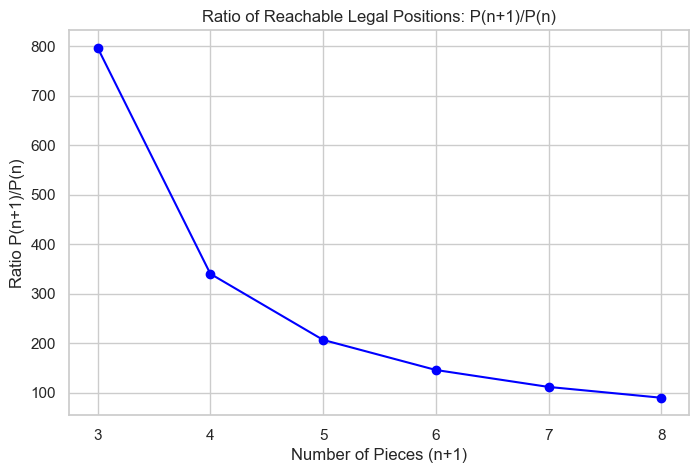

Fitted power-law parameters: c = 1.302e+04, d = 2.557
R² of power-law fit: 0.9922


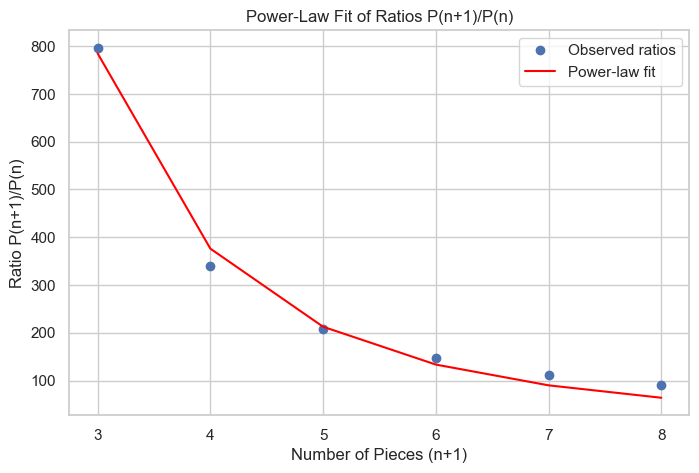


=== Predicted Reachable Positions (9 to 32 pieces) ===
    pieces  predicted_reachable_positions
0        9                      1.806e+18
1       10                      6.523e+19
2       11                      1.847e+21
3       12                      4.187e+22
4       13                      7.734e+23
5       14                      1.182e+25
6       15                      1.514e+26
7       16                      1.645e+27
8       17                      1.530e+28
9       18                      1.230e+29
10      19                      8.610e+29
11      20                      5.287e+30
12      21                      2.865e+31
13      22                      1.379e+32
14      23                      5.921e+32
15      24                      2.281e+33
16      25                      7.916e+33
17      26                      2.485e+34
18      27                      7.083e+34
19      28                      1.840e+35
20      29                      4.368e+35
21      30          

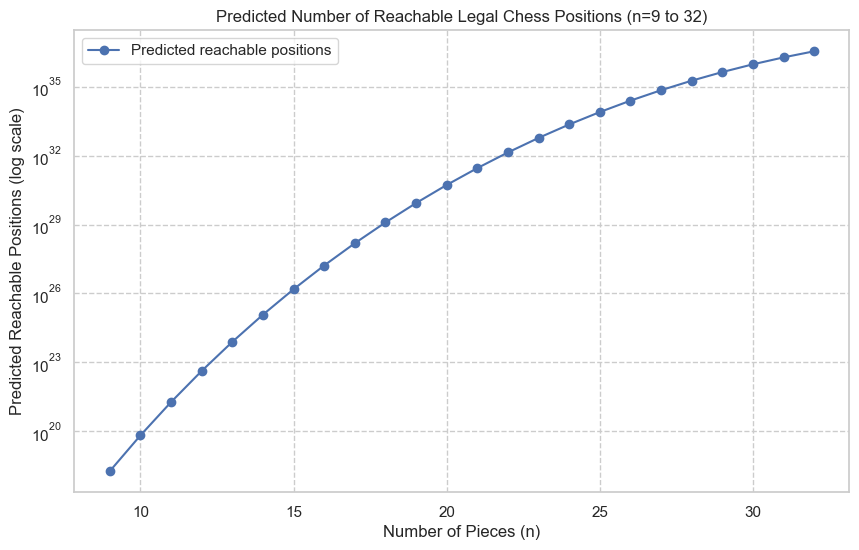

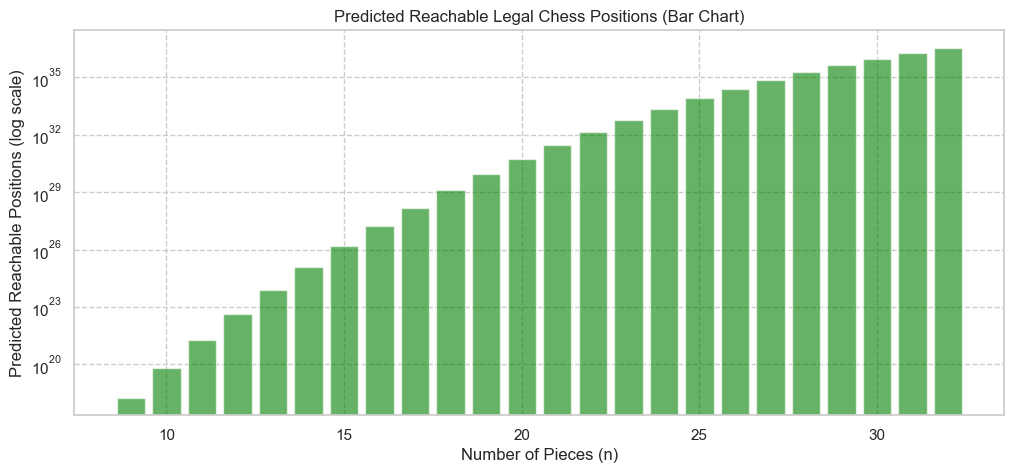


Methodology:
- Computed ratios P(n+1)/P(n) from tablebase data (up to 8 pieces).
- Fitted a power-law decay model to extrapolate future ratios.
- Used ratios iteratively to predict reachable positions up to 32 pieces.

Notes:
- Power-law chosen as it fits decreasing ratios better than exponential decay.
- Predictions assume ratios continue to follow similar decay; actual chess positions may differ.
- Visualizations use log scale to clearly show exponential growth trend.


Ethics and Data Management:
- Data is public (OEIS) and contains no personal information.
- Proper documentation of source and assumptions is provided.
- Predictions are illustrative; actual chess positions are subject to game legality rules.

Project Planning:
- Future steps could include integrating larger datasets, real chess game analysis, and UI visualization using Streamlit.


AI and Learning:
- Generative AI assisted with code structure, visualization ideas, and methodology explanation.
- Power-law choice and 

In [59]:
# =====================================================
# CAPSTONE PROJECT: Predicting Legal Chess Positions
# =====================================================
# Author: Joshua Tutin
# Description: Using OEIS tablebase data (https://oeis.org/A318266)
#              to predict reachable legal chess positions
# =====================================================

# -----------------------------
# Section 0: Imports
# -----------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# =====================================================
# Section 1: Load Tablebase Data
# LO1, LO2, LO3
# -----------------------------
pieces = np.array([2, 3, 4, 5, 6, 7, 8])
legal_positions = np.array([462, 368079, 125246598, 25912594054, 
                            3787154440416, 423836835667331, 38176306877748245])

df = pd.DataFrame({
    "pieces": pieces,
    "reachable_legal_positions": legal_positions
})
pd.set_option('display.float_format', lambda x: '%.3e' % x)
print("\n=== Tablebase Data ===")
print(df)

print("""
P(n) = Number of reachable legal chess positions with n pieces
P(n+1) = Number of reachable legal positions with one additional piece
""")

# =====================================================
# Section 2: Compute Ratios P(n+1)/P(n)
# LO1, LO2
# -----------------------------
ratios = legal_positions[1:] / legal_positions[:-1]
df_ratios = pd.DataFrame({
    "pieces": pieces[1:],
    "ratio": ratios
})
print("\n=== Ratios P(n+1)/P(n) ===")
print(df_ratios)

# =====================================================
# Section 3: Visualize Ratios
# LO2, LO8
# -----------------------------
plt.figure(figsize=(8,5))
plt.plot(df_ratios['pieces'], df_ratios['ratio'], 'o-', color='blue')
plt.title("Ratio of Reachable Legal Positions: P(n+1)/P(n)")
plt.xlabel("Number of Pieces (n+1)")
plt.ylabel("Ratio P(n+1)/P(n)")
plt.grid(True)
plt.show()

# =====================================================
# Section 4: Fit Power-Law Decay Model
# LO2, LO3, LO7
# -----------------------------
def power_law(x, c, d):
    return c * x**(-d)

xdata = df_ratios['pieces']
ydata = df_ratios['ratio']

params, _ = curve_fit(power_law, xdata, ydata)
c, d = params
print(f"Fitted power-law parameters: c = {c:.3e}, d = {d:.3f}")

# R^2 calculation
residuals = ydata - power_law(xdata, c, d)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((ydata - np.mean(ydata))**2)
r_squared = 1 - ss_res / ss_tot
print(f"R² of power-law fit: {r_squared:.4f}")

plt.figure(figsize=(8,5))
plt.plot(xdata, ydata, 'o', label="Observed ratios")
plt.plot(xdata, power_law(xdata, c, d), '-', label="Power-law fit", color='red')
plt.title("Power-Law Fit of Ratios P(n+1)/P(n)")
plt.xlabel("Number of Pieces (n+1)")
plt.ylabel("Ratio P(n+1)/P(n)")
plt.legend()
plt.grid(True)
plt.show()

# =====================================================
# Section 5: Predict P(n+1) up to n=32
# LO2, LO3, LO7
# -----------------------------
future_pieces = np.arange(9, 33)
predicted_ratios = power_law(future_pieces, c, d)

predicted_positions = [legal_positions[-1]]
for r in predicted_ratios:
    predicted_positions.append(predicted_positions[-1] * r)
predicted_positions = np.array(predicted_positions[1:])

df_pred = pd.DataFrame({
    "pieces": future_pieces,
    "predicted_reachable_positions": predicted_positions
})
print("\n=== Predicted Reachable Positions (9 to 32 pieces) ===")
print(df_pred)

# =====================================================
# Section 6: Visualize Predictions
# LO2, LO8
# -----------------------------
plt.figure(figsize=(10,6))
plt.plot(future_pieces, predicted_positions, 'o-', label="Predicted reachable positions")
plt.yscale("log")
plt.title("Predicted Number of Reachable Legal Chess Positions (n=9 to 32)")
plt.xlabel("Number of Pieces (n)")
plt.ylabel("Predicted Reachable Positions (log scale)")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

# Additional bar chart
plt.figure(figsize=(12,5))
plt.bar(future_pieces, predicted_positions, color='green', alpha=0.6)
plt.yscale("log")
plt.title("Predicted Reachable Legal Chess Positions (Bar Chart)")
plt.xlabel("Number of Pieces (n)")
plt.ylabel("Predicted Reachable Positions (log scale)")
plt.grid(True, which="both", ls="--")
plt.show()

# =====================================================
# Section 7: Methodology and Explanation
# LO1, LO3, LO4, LO7, LO8
# -----------------------------
print("""
Methodology:
- Computed ratios P(n+1)/P(n) from tablebase data (up to 8 pieces).
- Fitted a power-law decay model to extrapolate future ratios.
- Used ratios iteratively to predict reachable positions up to 32 pieces.

Notes:
- Power-law chosen as it fits decreasing ratios better than exponential decay.
- Predictions assume ratios continue to follow similar decay; actual chess positions may differ.
- Visualizations use log scale to clearly show exponential growth trend.
""")

# =====================================================
# Section 8: Ethical & Practical Considerations
# LO5, LO6, LO10
# -----------------------------
print("""
Ethics and Data Management:
- Data is public (OEIS) and contains no personal information.
- Proper documentation of source and assumptions is provided.
- Predictions are illustrative; actual chess positions are subject to game legality rules.

Project Planning:
- Future steps could include integrating larger datasets, real chess game analysis, and UI visualization using Streamlit.
""")

# =====================================================
# Section 9: AI Assistance & Research Reflection
# LO4, LO11
# -----------------------------
print("""
AI and Learning:
- Generative AI assisted with code structure, visualization ideas, and methodology explanation.
- Power-law choice and ratio method were informed by iterative AI suggestions.
- Demonstrates adaptation to new analytical approaches and tools.
""")







---

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* In cases where you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
  # create your folder here
  # os.makedirs(name='')
except Exception as e:
  print(e)
